In [23]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import classification_report

# =========================
# 1. Load Model Components
# =========================
model = joblib.load("models/best_rf_model.pkl")
scaler = joblib.load("models/scaler.pkl")
encoders = joblib.load("models/label_encoders.pkl")

# =========================
# 2. Load Race Data (with ground truth)
# =========================
df_original = pd.read_csv("2025-06-16.csv")
df_new = df_original.copy()

# =========================
# 3. Preprocess Data for Prediction
# =========================

# Handle missing values
df_new["SP"] = df_new["SP"].fillna(df_new["SP"].mean())
df_new["Trainer"] = df_new["Trainer"].fillna("UNKNOWN")

# Random fill for categorical columns
for col in ["Class", "Track Condition", "Weather"]:
    available_values = df_new[col].dropna().unique()
    df_new[col] = df_new[col].apply(lambda x: np.random.choice(available_values) if pd.isna(x) else x)

# Save identifiers for later merging
df_new["Race Number_Original"] = df_new["Race Number"]
df_new["Track_Original"] = df_new["Track"]

# Drop unused columns
df_new.drop(columns=["Date", "Race Number", "Finish Position", "Total Runners"], inplace=True, errors="ignore")

# =========================
# 4. Apply Label Encoding
# =========================
categorical_columns = encoders.keys()
for col in categorical_columns:
    if col in df_new.columns:
        le = encoders[col]
        df_new[col] = df_new[col].apply(lambda x: x if x in le.classes_ else "UNKNOWN")
        if "UNKNOWN" not in le.classes_:
            le.classes_ = np.append(le.classes_, "UNKNOWN")
        df_new[col] = le.transform(df_new[col])

# Save encoded horse column for inverse mapping
encoded_horses = df_new["Horse"].copy()

# =========================
# 5. Model Prediction
# =========================
features_to_use = scaler.feature_names_in_
X_scaled = scaler.transform(df_new[features_to_use])

y_pred = model.predict(X_scaled)
y_proba = model.predict_proba(X_scaled)[:, 1]

# Decode horse names and attach predictions
df_new["Horse"] = encoders["Horse"].inverse_transform(encoded_horses)
df_new["Top4_Predicted"] = y_pred
df_new["Confidence_Top4"] = y_proba

# Restore original race info
df_new["Race Number"] = df_new["Race Number_Original"]
df_new["Track"] = df_new["Track_Original"]
df_new.drop(columns=["Race Number_Original", "Track_Original"], inplace=True)

# =========================
# 6. Merge with Actual Results
# =========================
merge_cols = ["Horse", "Track", "Race Number"]
df_merged = pd.merge(
    df_new,
    df_original[merge_cols + ["Finish Position", "Total Runners"]],
    on=merge_cols,
    how="left"
)

# =========================
# 7. Evaluate Predictions per Race (with confidence)
# =========================

race_results = []
grouped_races = df_merged.groupby(["Track", "Race Number"])

for (track, race_num), group in grouped_races:
    total_runners = group.shape[0]
    if total_runners < 8:
        continue  # Skip races with fewer than 8 runners

    # Top 4 predicted by confidence
    top4_predicted = group.sort_values(by="Confidence_Top4", ascending=False).head(4)

    for _, row in top4_predicted.iterrows():
        horse = row["Horse"]
        conf = row["Confidence_Top4"]
        actual_pos = row["Finish Position"]

        race_results.append({
            "Track": track,
            "Race Number": race_num,
            "Horse": horse,
            "Confidence": round(conf, 4),
            "Predicted Top 4": True,
            "Actually in Top 4": bool(pd.notna(actual_pos) and actual_pos <= 4),
            "Finish Position": actual_pos
        })


# =========================
# 8. Display Final Results
# =========================
results_df = pd.DataFrame(race_results)

print("Top 4 Horses with Prediction Confidence:\n")
print(results_df.head(10))

# Average correct from top 4
avg_correct = results_df["Actually in Top 4"].sum() / (results_df.shape[0] / 4)
print(f"\nAverage correct Top-4 per race: {avg_correct:.2f} / 4")

# Optional: save
results_df.to_csv("top4_detailed_predictions.csv", index=False)


Top 4 Horses with Prediction Confidence:

    Track  Race Number               Horse  Confidence  Predicted Top 4  \
0  ALBURY            1           DEFLECTOR      0.7317             True   
1  ALBURY            1         MISS PEPEHA      0.7294             True   
2  ALBURY            1     BESSIE LA BELLE      0.7244             True   
3  ALBURY            1          COLOMBIANO      0.6314             True   
4  ALBURY            2         DONEGAL BAY      0.8431             True   
5  ALBURY            2  TALLINGAS IMMORTAL      0.5902             True   
6  ALBURY            2          LUNAR MOJO      0.4969             True   
7  ALBURY            2         LADY DUTTON      0.3983             True   
8  ALBURY            3       BLAZING SWORD      0.7306             True   
9  ALBURY            3        BROKEN IMAGE      0.5581             True   

   Actually in Top 4  Finish Position  
0               True              3.0  
1               True              2.0  
2           

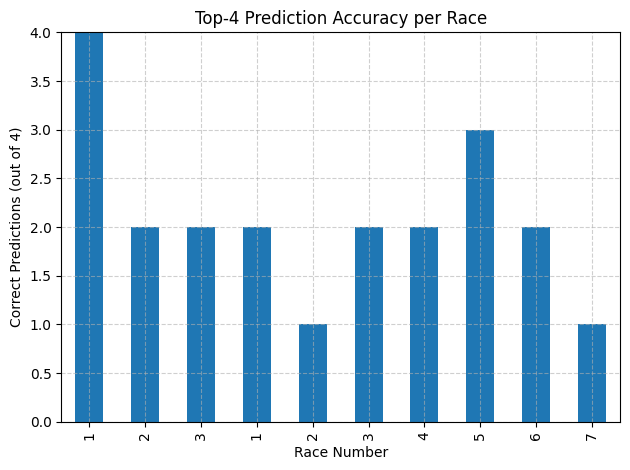

In [22]:
import matplotlib.pyplot as plt

results_df.plot(kind='bar', x='Race Number', y='Correct Predictions (Top 4)', legend=False)
plt.title("Top-4 Prediction Accuracy per Race")
plt.ylabel("Correct Predictions (out of 4)")
plt.xlabel("Race Number")
plt.ylim(0, 4)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()